In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import collections
import random
from tqdm import trange
from IPython.display import clear_output
import time
import psutil
from scipy.signal import fftconvolve, gaussian

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

seed = 228
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def is_enough_ram(min_available_gb=0.1):
    mem = psutil.virtual_memory()
    return mem.available >= min_available_gb * (1024 ** 3)


def linear_decay(init_val, final_val, cur_step, total_steps):
    if cur_step >= total_steps:
        return final_val
    return (init_val * (total_steps - cur_step) +
            final_val * cur_step) / total_steps


def smoothen(values):
    kernel = gaussian(100, std=100)
    # kernel = np.concatenate([np.arange(100), np.arange(99, -1, -1)])
    kernel = kernel / np.sum(kernel)
    return fftconvolve(values, kernel, 'valid')


def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

 # Environment

In [3]:
def sample_uniform(sample_range, size, integers_only=False):
    if isinstance(sample_range, collections.Sequence):
        if integers_only:
            return np.random.randint(sample_range[0], sample_range[1], size=size)
        return np.random.uniform(sample_range[0], sample_range[1], size=size)
    return np.full(size, sample_range)


def ode_euler(f, y0, t):
    '''
    Approximate the solution of y'=f(y,t) by Euler's method.

    Parameters
    ----------
    f : function
        Right-hand side of the differential equation y'=f(y,t), y(t_0)=y_0
    y0 : number
        Initial value y(t0)=y0 where t0 is the entry at index 0 in the array t
    t : array
        1D NumPy array of t values where we approximate y values. Time step
        at each iteration is given by t[n+1] - t[n].

    Returns
    -------
    y : 1D NumPy array
        Approximation y[n] of the solution y(t_n) computed by Euler's method.
    '''
    y = np.zeros((len(t), y0.shape[0]))
    y[0] = y0
    for n in range(0,len(t) - 1):
        y[n + 1] = y[n] + f(y[n], t[n]) * (t[n + 1] - t[n])

    return y


def calculate_integral_of_piecewise_linear_function(y, t):
    '''
    Calculates integral from piecewise linear function

    Parameters
    ----------
    y : 2D NumPy array
        Should contain values of the function at points t[i] (parameter below),
        between which the function is counted to be linear
    t : 1D NumPy array
        The points that should correspond to the function values from previous
        parameter
    '''
    assert y.shape[0] == t.shape[0], 'Length of y and t must match'

    result = np.zeros(y.shape[1])
    for i in range(1, len(t)):
        linear_coef = (y[i] - y[i - 1]) / (t[i] - t[i - 1])
        bias = y[i - 1] - linear_coef * t[i - 1]
        result += linear_coef / 2 * t[i]**2 + bias * t[i] - \
                  linear_coef / 2 * t[i - 1]**2 - bias * t[i - 1]

    return result


class CapitalLaborEnvironment:
    def __init__(self, n_countries, n_steps, n_discrete_sigma, n_discrete_tau,
                 n_actions_per_parameter, n_euler_segments,
                 output_elasticity, population_growth_rate, depreciation_rate,
                 saving_rate, lambda0, capital_output_ratio, rho0, sigma_range,
                 tau_range, sampling_mode=False):
        assert n_actions_per_parameter % 2, "n_actions_per_parameter must be odd number"

        self.n_countries = n_countries
        self.n_steps = n_steps
        self.n_discrete_sigma = n_discrete_sigma
        self.n_discrete_tau = n_discrete_tau
        self.n_actions_per_parameter = n_actions_per_parameter
        self.n_euler_segments = n_euler_segments
        self.sampling_mode = sampling_mode

        if sampling_mode:
            self.output_elasticity_range = output_elasticity
            self.output_elasticity = None
            self.population_growth_rate_range = population_growth_rate
            self.population_growth_rate = None
            self.depreciation_rate_range = depreciation_rate
            self.depreciation_rate = None
            self.saving_rate_range = saving_rate
            self.saving_rate = None
            self.lambda0_range = lambda0
            self.lambda0 = None
            self.capital_output_ratio_range = capital_output_ratio
            self.capital_output_ratio = None
            self.rho0_range = rho0
            self.rho0 = None
        else:
            self.output_elasticity = np.array(output_elasticity)
            self.population_growth_rate = np.array(population_growth_rate)
            self.depreciation_rate = np.array(depreciation_rate)
            self.saving_rate = np.array(saving_rate)
            self.lambda0 = np.array(lambda0)
            self.capital_output_ratio = np.array(capital_output_ratio)
            self.rho0 = np.array(rho0)

        self.pi0 = None

        self.sigma_grid = np.linspace(sigma_range[0], sigma_range[1], num=n_discrete_sigma)
        self.sigma_index = None
        self.tau_grid = np.linspace(tau_range[0], tau_range[1], num=n_discrete_tau)
        self.tau_index = None
        self.sigma = None
        self.tau = None

        self.capital0 = None
        self.labour0 = None

        self.previous_rewards = None
        self.penalty_for_policy_change = None

        self.current_step = None
    
    def _get_state(self):
        return np.hstack([np.array([self.current_step / self.n_steps]), self.capital0,
                          self.labour0, self.sigma_index.reshape(-1) / (self.n_discrete_sigma - 1),
                          self.tau_index.reshape(-1) / (self.n_discrete_tau - 1)])

    def _capital_labour_differential(self, capital_labour, t):
        capital_differential = np.zeros(self.n_countries)
        labour_differential = np.zeros(self.n_countries)
        capital = capital_labour[:self.n_countries]
        labour = capital_labour[self.n_countries:]

        r = np.zeros(self.n_countries)
        w = np.zeros(self.n_countries)
        for country_index in range(self.n_countries):
            r[country_index] = self.capital_output_ratio[country_index] * self.output_elasticity[country_index] * \
                               (labour[country_index] / capital[country_index])**(1 - self.output_elasticity[country_index])
            w[country_index] = self.lambda0[country_index] * (1 - self.output_elasticity[country_index]) * \
                               (capital[country_index] / labour[country_index])**self.output_elasticity[country_index]
        
        for i in range(self.n_countries):
            y = capital[i]**self.output_elasticity[i] * labour[i]**(1 - self.output_elasticity[i])

            capital_differential[i] = self.saving_rate[i] * self.capital_output_ratio[i] * y
            capital_differential[i] -= self.depreciation_rate[i] * capital[i]

            labour_differential[i] = self.population_growth_rate[i] * labour[i]

            for j in range(self.n_countries):
                if i == j:
                    continue

                if r[i] > r[j]:
                    capital_differential[i] += self.tau[i, j] * (r[i] - r[j]) * self.pi0[j, i] * capital[j]
                else:
                    capital_differential[i] -= self.tau[j, i] * (r[j] - r[i]) * capital[i]

                if w[i] > w[j]:
                    labour_differential[i] += self.sigma[i, j] * (w[i] - w[j]) / w[j] * self.rho0[j, i] * labour[j]
                else:
                    labour_differential[i] -= self.sigma[j, i] * (w[j] - w[i]) / w[i] * labour[i]

        return np.hstack([capital_differential, labour_differential])
            
    
    def _get_rewards(self, finish_step=True):
        t = np.linspace(0, 1, self.n_euler_segments)
        capital_labour_approx = ode_euler(lambda y, t: self._capital_labour_differential(y, t),
                                          np.hstack([self.capital0.reshape(-1), self.labour0.reshape(-1)]), t)

        k = capital_labour_approx[:, :self.n_countries]
        l = capital_labour_approx[:, self.n_countries:]
        y = k**self.output_elasticity * l**(1 - self.output_elasticity)

        f_values = np.vstack([
            l[i] * np.log((1 - self.saving_rate) * self.lambda0 * k[i]**self.output_elasticity * l[i]**(1 - self.output_elasticity) / l[i])
            for i in range(len(t))
        ])

        rewards = calculate_integral_of_piecewise_linear_function(f_values, t)

        if finish_step:
            self.capital0 = capital_labour_approx[-1, :self.n_countries]
            self.labour0 = capital_labour_approx[-1, self.n_countries:]

        return rewards

    def get_state_shape(self):
        return self._get_state().shape

    def get_actions_count(self):
        return self.n_actions_per_parameter**(4 * (self.n_countries - 1))

    def _update_sigma_tau(self):
        self.sigma = np.zeros([self.n_countries, self.n_countries])
        self.tau = np.zeros([self.n_countries, self.n_countries])
        for country_first in range(self.n_countries):
            for country_second in range(self.n_countries):
                if country_first < country_second:
                    # sigma
                    first_sigma = self.sigma_grid[self.sigma_index[country_first][country_second - 1][0]]
                    second_sigma = self.sigma_grid[self.sigma_index[country_second][country_first][1]]
                    self.sigma[country_first, country_second] = (first_sigma + second_sigma) / 2
                    # tau
                    first_tau = self.tau_grid[self.tau_index[country_first][country_second - 1][0]]
                    second_tau = self.tau_grid[self.tau_index[country_second][country_first][1]]
                    self.tau[country_first, country_second] = (first_tau + second_tau) / 2
                elif country_first > country_second:
                    # sigma
                    first_sigma = self.sigma_grid[self.sigma_index[country_first][country_second][0]]
                    second_sigma = self.sigma_grid[self.sigma_index[country_second][country_first - 1][1]]
                    self.sigma[country_first, country_second] = (first_sigma + second_sigma) / 2
                    # tau
                    first_tau = self.tau_grid[self.tau_index[country_first][country_second][0]]
                    second_tau = self.tau_grid[self.tau_index[country_second][country_first - 1][1]]
                    self.tau[country_first, country_second] = (first_tau + second_tau) / 2
                

    def reset(self):
        if self.sampling_mode:
            self.output_elasticity = sample_uniform(self.output_elasticity_range, self.n_countries)
            self.population_growth_rate = sample_uniform(self.population_growth_rate_range, self.n_countries)
            self.depreciation_rate = sample_uniform(self.depreciation_rate_range, self.n_countries)
            self.saving_rate = sample_uniform(self.saving_rate_range, self.n_countries)
            self.lambda0 = sample_uniform(self.lambda0_range, self.n_countries)
            self.capital_output_ratio = sample_uniform(self.capital_output_ratio_range, self.n_countries)
            self.rho0 = sample_uniform(self.rho0_range, self.n_countries)

        self.pi0 = np.ones([self.n_countries, self.n_countries])
        for i in range(self.n_countries):
            for j in range(self.n_countries):
                self.pi0[i, j] = self.lambda0[i] / self.lambda0[j] * self.capital_output_ratio[i] / \
                                 self.capital_output_ratio[j] * self.rho0[i, j]

        self.sigma_index = sample_uniform([0, self.n_discrete_sigma], (self.n_countries, self.n_countries - 1, 2), integers_only=True)
        self.tau_index = sample_uniform([0, self.n_discrete_tau], (self.n_countries, self.n_countries - 1, 2), integers_only=True)
        self._update_sigma_tau()

        self.capital0 = np.ones(self.n_countries)
        self.labour0 = np.ones(self.n_countries)

        self.current_step = 0

        self.penalty_for_policy_change = np.zeros(self.n_countries)
        self.previous_rewards = self._get_rewards(finish_step=False)

        return self._get_state()
    
    def _perform_action(self, country_index, action):
        assert 0 <= action < self.get_actions_count(), "Incorrect action."

        self.penalty_for_policy_change[country_index] = 0

        divider = 1
        new_sigma_index = []
        for i in range(self.n_countries - 1):
            for j in range(2):
                index_shift = (action // divider) % self.n_actions_per_parameter - self.n_actions_per_parameter // 2
                divider *= self.n_actions_per_parameter
                new_sigma_index.append(np.clip(self.sigma_index[country_index][i][j] + index_shift, 0, self.n_discrete_sigma - 1))
                self.penalty_for_policy_change[country_index] += abs(index_shift)

        new_tau_index = []
        for i in range(self.n_countries - 1):
            for j in range(2):
                index_shift = (action // divider) % self.n_actions_per_parameter - self.n_actions_per_parameter // 2
                divider *= self.n_actions_per_parameter
                new_tau_index.append(np.clip(self.tau_index[country_index][i][j] + index_shift, 0, self.n_discrete_tau - 1))
                self.penalty_for_policy_change[country_index] += abs(index_shift)

        self.sigma_index[country_index] = np.array(new_sigma_index).reshape(-1, 2)
        self.tau_index[country_index] = np.array(new_tau_index).reshape(-1, 2)
    
    def step(self, actions):
        assert self.current_step < self.n_steps, \
               "Trying to make action in finished session. Try env.reset() first"
        assert len(actions) == self.n_countries, \
               "Number of actions and countries should match"
        
        for i in range(self.n_countries):
            self._perform_action(i, actions[i])
        self._update_sigma_tau()

        current_rewards = self._get_rewards()
        rewards_return = (current_rewards - self.previous_rewards) / current_rewards
        self.previous_rewards = current_rewards

        self.current_step += 1

        return self._get_state(), rewards_return / self.n_steps * 100, self.current_step == self.n_steps

In [4]:
def make_env(n_steps=100):
    return CapitalLaborEnvironment(
        n_countries=2,
        n_steps=n_steps,
        n_discrete_sigma=10,
        n_discrete_tau=10,
        n_actions_per_parameter=3,
        n_euler_segments=11,
        output_elasticity=[1/3, 1/3],
        population_growth_rate=[0.0143, 0.0042],
        depreciation_rate=[0.05, 0.05],
        saving_rate=[0.2185, 0.228],
        lambda0=[12369, 91363],
        capital_output_ratio=[0.324, 0.2193],
        rho0=[[1, 5.4], [1/5.4, 1]],
        sigma_range=[0, 0.003],
        tau_range=[0, 0.7]
    )

In [5]:
env = make_env()
env.reset()

<ipython-input-3-43a8e2fb8151>:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(sample_range, collections.Sequence):


array([0.        , 1.        , 1.        , 1.        , 1.        ,
       0.55555556, 0.        , 0.33333333, 1.        , 0.88888889,
       0.77777778, 0.88888889, 0.33333333])

In [6]:
env.step([0, 0])

(array([0.01      , 1.03153108, 0.98868454, 1.01225538, 1.01569528,
        0.44444444, 0.        , 0.22222222, 0.88888889, 0.77777778,
        0.66666667, 0.77777778, 0.22222222]),
 array([ 0.00046711, -0.00271379]),
 False)

# Initializing DQN Agent

In [7]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        self.network = nn.Sequential(
            nn.Linear(state_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of observations, shape = [batch_size, state_shape]
        """
        # Using network to compute qvalues for given state
        qvalues = self.network(state_t)

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and 
            qvalues.shape[0] == state_t.shape[0] and 
            qvalues.shape[1] == self.n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """
        pick actions given qvalues. Uses epsilon-greedy exploration strategy
        """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)


# Evaluation Pipeline

In [8]:
def evaluate(env, agents, n_games=1, greedy=False, t_max=1000, with_history=False):
    """
    Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward
    """
    rewards = [[] for _ in range(len(agents))]
    if with_history:
        rewards_history = [[] for _ in range(len(agents))]
    for _ in range(n_games):
        s = env.reset()
        game_rewards = [0] * len(agents)
        for _ in range(t_max):
            actions = []
            for agent in agents:
                qvalues = agent.get_qvalues([s])
                actions.append(qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0])
            s, r_all, done = env.step(actions)
            for i, r_agent in enumerate(r_all):
                game_rewards[i] += r_agent
                if with_history:
                    rewards_history[i].append(r_agent)
            if done:
                break
        for i in range(len(agents)):
            rewards[i].append(game_rewards[i])
    
    if with_history:
        return np.mean(rewards, axis=1), rewards_history

    return np.mean(rewards, axis=1)

In [9]:
agent = DQNAgent(env.get_state_shape()[0], env.get_actions_count(), epsilon=1).to(device)
r_mean, r_history = evaluate(env, [agent, agent], n_games=1, with_history=True)
r_mean

<ipython-input-7-a3e0dd421354>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272106004/work/torch/csrc/utils/tensor_new.cpp:201.)
  states = torch.tensor(states, device=model_device, dtype=torch.float32)


array([0.81757249, 1.89435362])

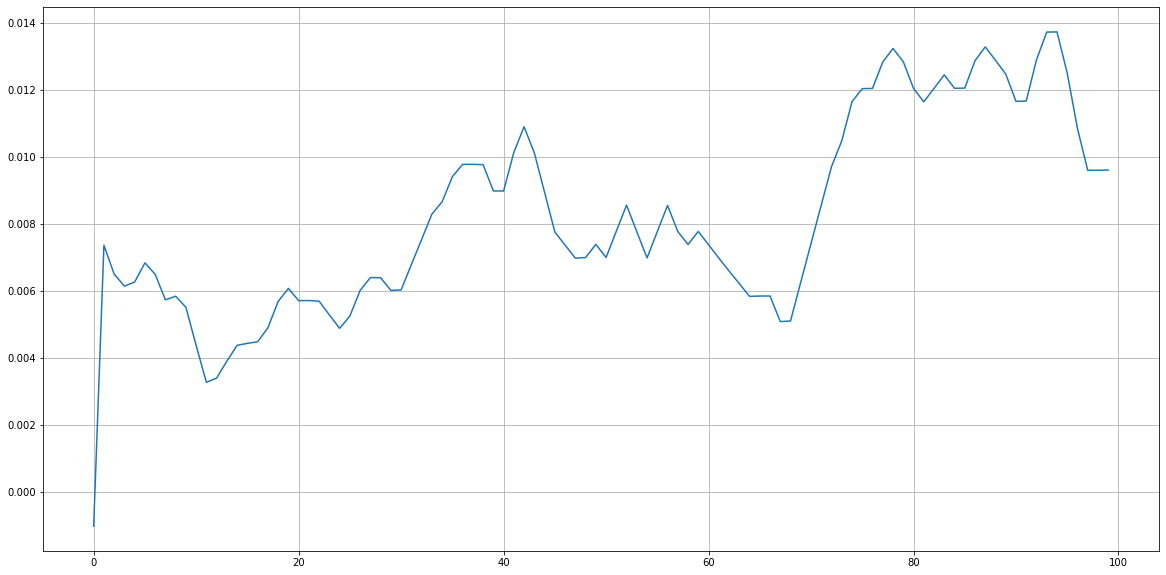

In [10]:
plt.plot(r_history[0])
plt.grid()

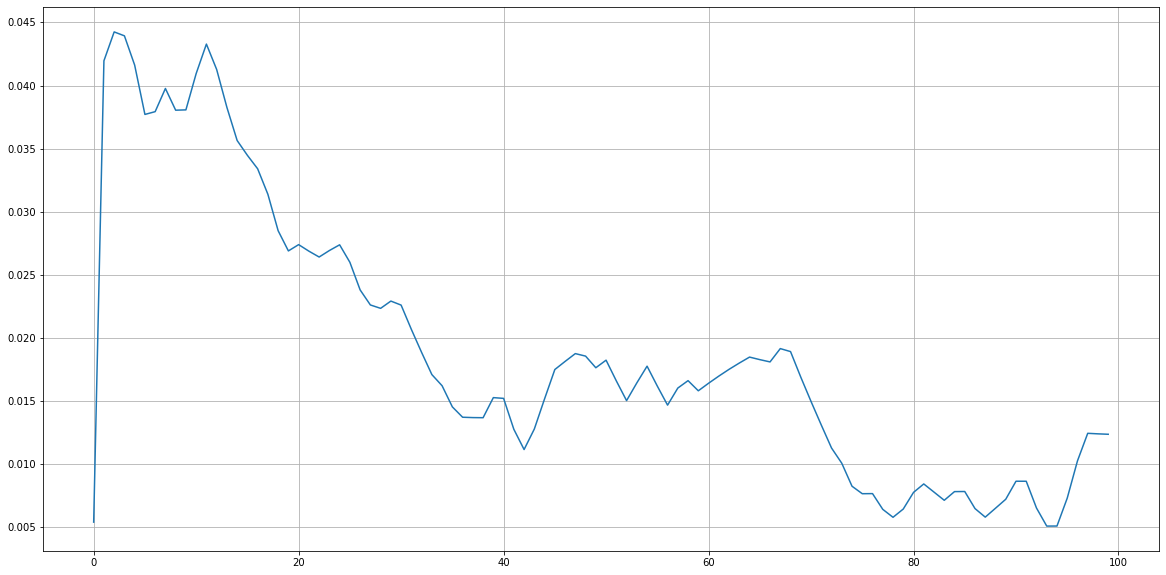

In [11]:
plt.plot(r_history[1])
plt.grid()

# Replay Buffer

In [12]:
# This code is shamelessly stolen from
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

In [13]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), np.random.choice(env.get_actions_count(), 2), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [14]:
def play_and_record(initial_state, agents, env, exp_replays, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = np.zeros(len(agents))

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        actions = []
        for agent in agents:
            qvalues = agent.get_qvalues([s])
            actions.append(qvalues.argmax(axis=-1)[0])
        next_s, r_all, done = env.step(actions)
        sum_rewards += np.array(r_all)
        for i, exp_replay in enumerate(exp_replays):
            exp_replay.add(s, actions[i], r_all[i], next_s, done)
        s = next_s
        if done:
            s = env.reset()

    return sum_rewards.tolist(), s

In [15]:
# testing your code.
exp_replays = [ReplayBuffer(2000), ReplayBuffer(2000)]

state = env.reset()
play_and_record(state, [agent, agent], env, exp_replays, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replays[0]) == 1000, \
    "play_and_record should have added exactly 1000 steps, " \
    "but instead added %i" % len(exp_replays[0])

is_dones = list(zip(*exp_replays[0]._storage))[-1]

assert 0 < np.mean(is_dones) <= 0.1, \
    "Please make sure you restart the game whenever it is 'done' and " \
    "record the is_done correctly into the buffer. Got %f is_done rate over " \
    "%i steps. [If you think it's your tough luck, just re-run the test]" % (
        np.mean(is_dones), len(exp_replays[0]))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replays[0].sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + env.get_state_shape()
    assert act_batch.shape == (10,), \
        "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), \
        "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), \
        "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done should be strictly True or False"
    assert [0 <= a < env.get_actions_count() for a in act_batch], "actions should be within [0, n_actions)"

print("Life is good!")

Life is good!


# Target Network

In [16]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Computing Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes Q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor

In [17]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ 
    Computes td loss using torch operations only
    """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, axis=1)[0]

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # we multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + is_not_done * gamma * next_state_values

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, \
            "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "there's something wrong with target q-values, they must be a vector"

    return loss

In [18]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replays[0].sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), \
    "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), \
    "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), \
    "target network should not have grads"

# Training

## Both Agents Training

In [19]:
env = make_env()

state = env.reset()
state_shape = env.get_state_shape()[0]
n_actions = env.get_actions_count()

agents_both = [DQNAgent(state_shape, n_actions, epsilon=1).to(device),
               DQNAgent(state_shape, n_actions, epsilon=1).to(device)]
target_networks = [DQNAgent(state_shape, n_actions).to(device),
                   DQNAgent(state_shape, n_actions).to(device)]

for i in range(2):
    target_networks[i].load_state_dict(agents_both[i].state_dict())

In [20]:
REPLAY_BUFFER_SIZE = 10**4
N_STEPS = 100

exp_replays = [ReplayBuffer(REPLAY_BUFFER_SIZE),
               ReplayBuffer(REPLAY_BUFFER_SIZE)]
for i in trange(REPLAY_BUFFER_SIZE // N_STEPS):
    play_and_record(state, agents_both, env, exp_replays, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replays[0]))

100%|██████████| 100/100 [00:11<00:00,  8.61it/s]

10000


In [21]:
timesteps_per_epoch = 1
batch_size = 64
total_steps = 3 * 10**6
decay_steps = 10**6

opts = []
for agent in agents_both:
    opts.append(torch.optim.Adam(agent.parameters(), lr=5e-5))

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

In [22]:
mean_rw_history = [[], []]
td_loss_history = [[], []]
grad_norm_history = [[], []]
initial_state_v_history = [[], []]
step = 0
colors = ['blue', 'red']
agent_names = ['Развивающаяся Страна', 'Развитая Страна']

buffer size = 10000, epsilon = 0.42850


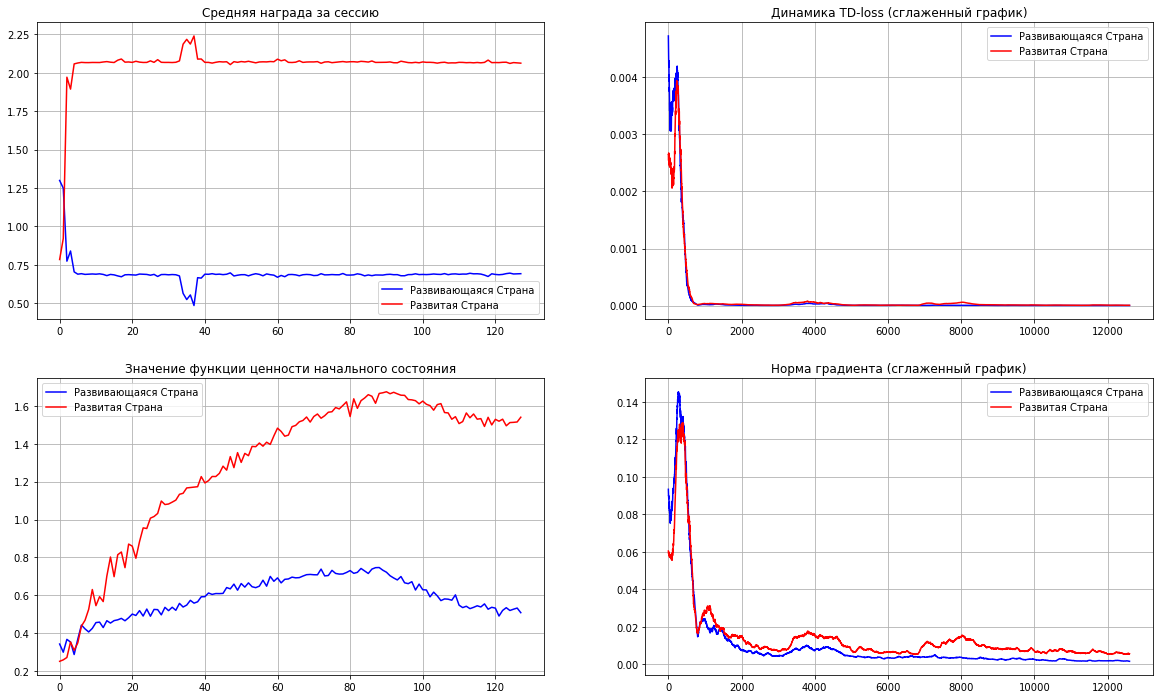

 21%|██▏       | 637952/3000001 [1:27:21<5:23:26, 121.72it/s]


KeyboardInterrupt: 

In [23]:
state = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        for agent in agents_both:
            agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agents_both, env, exp_replays, timesteps_per_epoch)

        # train
        for i in range(len(agents_both)):
            # sampling batch_size of data from experience replay>
            s_batch, a_batch, r_batch, next_s_batch, done_batch = exp_replays[i].sample(batch_size)

            loss = compute_td_loss(s_batch, a_batch, r_batch, next_s_batch, done_batch,
                                   agents_both[i], target_networks[i])

            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(agents_both[i].parameters(), max_grad_norm)
            opts[i].step()
            opts[i].zero_grad()

            if step % loss_freq == 0:
                td_loss_history[i].append(loss.data.cpu().item())
                grad_norm_history[i].append(grad_norm.cpu())

            if step % refresh_target_network_freq == 0:
                # Load agent weights into target_network
                target_networks[i].load_state_dict(agents_both[i].state_dict())

        if step % eval_freq == 0:
            rewards = (evaluate(
                make_env(), agents_both, n_games=50, greedy=True)
            )
            for i in range(len(agents_both)):
                mean_rw_history[i].append(rewards[i])
                initial_state_q_values = agents_both[i].get_qvalues(
                    [make_env().reset()]
                )
                initial_state_v_history[i].append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replays[0]), agents_both[0].epsilon))

            fig = plt.figure(figsize=[20, 12])
            axes = fig.subplots(2, 2)

            for i in range(len(agents_both)):
                axes[0][0].plot(mean_rw_history[i], c=colors[i], label=agent_names[i])

                assert not np.isnan(td_loss_history[i][-1])
                axes[0][1].plot(smoothen(td_loss_history[i]), c=colors[i], label=agent_names[i])

                axes[1][0].plot(initial_state_v_history[i], c=colors[i], label=agent_names[i])

                axes[1][1].plot(smoothen(grad_norm_history[i]), c=colors[i], label=agent_names[i])
            
            axes[0][0].set_title('Средняя награда за сессию')
            axes[0][0].grid()
            axes[0][0].legend()

            axes[0][1].set_title("Динамика TD-loss (сглаженный график)")
            axes[0][1].grid()
            axes[0][1].legend()
            
            axes[1][0].set_title("Значение функции ценности начального состояния")
            axes[1][0].grid()
            axes[1][0].legend()
            
            axes[1][1].set_title("Норма градиента (сглаженный график)")
            axes[1][1].grid()
            axes[1][1].legend()

            plt.show()

In [24]:
evaluate(make_env(), agents_both, n_games=100, greedy=True)

array([0.6935016 , 2.06566251])

In [101]:
evaluate(make_env(), [ClosedBordersAgent(n_actions), OpenedBordersAgent(n_actions)], n_games=100, greedy=True)

array([0.68840494, 2.06783972])

## First Agent Training

In [38]:
env = make_env()

state = env.reset()
state_shape = env.get_state_shape()[0]
n_actions = env.get_actions_count()

agents_first = [DQNAgent(state_shape, n_actions, epsilon=1).to(device),
                DQNAgent(state_shape, n_actions, epsilon=1).to(device)]
target_networks = [DQNAgent(state_shape, n_actions).to(device),
                   DQNAgent(state_shape, n_actions).to(device)]

for i in range(2):
    target_networks[i].load_state_dict(agents_first[i].state_dict())

In [39]:
REPLAY_BUFFER_SIZE = 10**4
N_STEPS = 100

exp_replays = [ReplayBuffer(REPLAY_BUFFER_SIZE),
               ReplayBuffer(REPLAY_BUFFER_SIZE)]
for i in trange(REPLAY_BUFFER_SIZE // N_STEPS):
    play_and_record(state, agents_first, env, exp_replays, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replays[0]))

100%|██████████| 100/100 [00:10<00:00,  9.38it/s]

10000


In [40]:
timesteps_per_epoch = 1
batch_size = 64
total_steps = 3 * 10**6
decay_steps = 10**6

opts = []
for agent in agents_first:
    opts.append(torch.optim.Adam(agent.parameters(), lr=5e-5))

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

In [41]:
mean_rw_history = [[], []]
td_loss_history = [[], []]
grad_norm_history = [[], []]
initial_state_v_history = [[], []]
step = 0
colors = ['blue', 'red']
agent_names = ['Развивающаяся Страна', 'Развитая Страна']

buffer size = 10000, epsilon = 0.10000


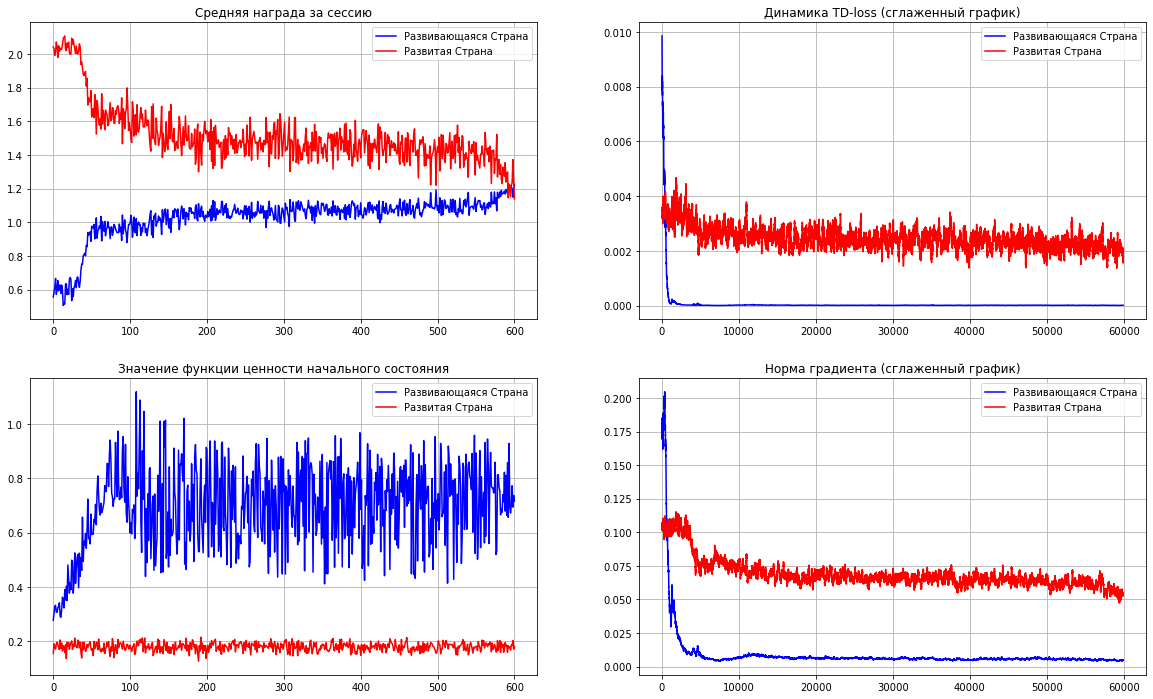

100%|██████████| 3000001/3000001 [6:05:50<00:00, 136.67it/s]


In [42]:
state = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        for agent in agents_first:
            agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agents_first, env, exp_replays, timesteps_per_epoch)

        # train
        for i in range(len(agents_first)):
            # sampling batch_size of data from experience replay>
            s_batch, a_batch, r_batch, next_s_batch, done_batch = exp_replays[i].sample(batch_size)

            loss = compute_td_loss(s_batch, a_batch, r_batch, next_s_batch, done_batch,
                                   agents_first[i], target_networks[i])

            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(agents_first[i].parameters(), max_grad_norm)
            if i == 0:
                opts[i].step()
            opts[i].zero_grad()

            if step % loss_freq == 0:
                td_loss_history[i].append(loss.data.cpu().item())
                grad_norm_history[i].append(grad_norm.cpu())

            if step % refresh_target_network_freq == 0:
                # Load agent weights into target_network
                target_networks[i].load_state_dict(agents_first[i].state_dict())

        if step % eval_freq == 0:
            rewards = (evaluate(
                make_env(), agents_first, n_games=50, greedy=True)
            )
            for i in range(len(agents_first)):
                mean_rw_history[i].append(rewards[i])
                initial_state_q_values = agents_first[i].get_qvalues(
                    [make_env().reset()]
                )
                initial_state_v_history[i].append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replays[0]), agents_first[0].epsilon))

            fig = plt.figure(figsize=[20, 12])
            axes = fig.subplots(2, 2)

            for i in range(len(agents_first)):
                axes[0][0].plot(mean_rw_history[i], c=colors[i], label=agent_names[i])

                assert not np.isnan(td_loss_history[i][-1])
                axes[0][1].plot(smoothen(td_loss_history[i]), c=colors[i], label=agent_names[i])

                axes[1][0].plot(initial_state_v_history[i], c=colors[i], label=agent_names[i])

                axes[1][1].plot(smoothen(grad_norm_history[i]), c=colors[i], label=agent_names[i])
            
            axes[0][0].set_title('Средняя награда за сессию')
            axes[0][0].grid()
            axes[0][0].legend()

            axes[0][1].set_title("Динамика TD-loss (сглаженный график)")
            axes[0][1].grid()
            axes[0][1].legend()
            
            axes[1][0].set_title("Значение функции ценности начального состояния")
            axes[1][0].grid()
            axes[1][0].legend()
            
            axes[1][1].set_title("Норма градиента (сглаженный график)")
            axes[1][1].grid()
            axes[1][1].legend()

            plt.show()

In [41]:
evaluate(make_env(), agents_first, n_games=100, greedy=True)

array([1.22843495, 1.06020748])

## Second Agent Training

In [19]:
env = make_env()

state = env.reset()
state_shape = env.get_state_shape()[0]
n_actions = env.get_actions_count()

agents_second = [DQNAgent(state_shape, n_actions, epsilon=1).to(device),
          DQNAgent(state_shape, n_actions, epsilon=1).to(device)]
target_networks = [DQNAgent(state_shape, n_actions).to(device),
                   DQNAgent(state_shape, n_actions).to(device)]

for i in range(2):
    target_networks[i].load_state_dict(agents_second[i].state_dict())

In [20]:
REPLAY_BUFFER_SIZE = 10**4
N_STEPS = 100

exp_replays = [ReplayBuffer(REPLAY_BUFFER_SIZE),
               ReplayBuffer(REPLAY_BUFFER_SIZE)]
for i in trange(REPLAY_BUFFER_SIZE // N_STEPS):
    play_and_record(state, agents_second, env, exp_replays, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replays[0]))

100%|██████████| 100/100 [00:11<00:00,  8.73it/s]

10000


In [21]:
timesteps_per_epoch = 1
batch_size = 64
total_steps = 3 * 10**6
decay_steps = 10**6

opts = []
for agent in agents_second:
    opts.append(torch.optim.Adam(agent.parameters(), lr=5e-5))

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

In [22]:
mean_rw_history = [[], []]
td_loss_history = [[], []]
grad_norm_history = [[], []]
initial_state_v_history = [[], []]
step = 0
colors = ['blue', 'red']
agent_names = ['Развивающаяся Страна', 'Развитая Страна']

buffer size = 10000, epsilon = 0.10000


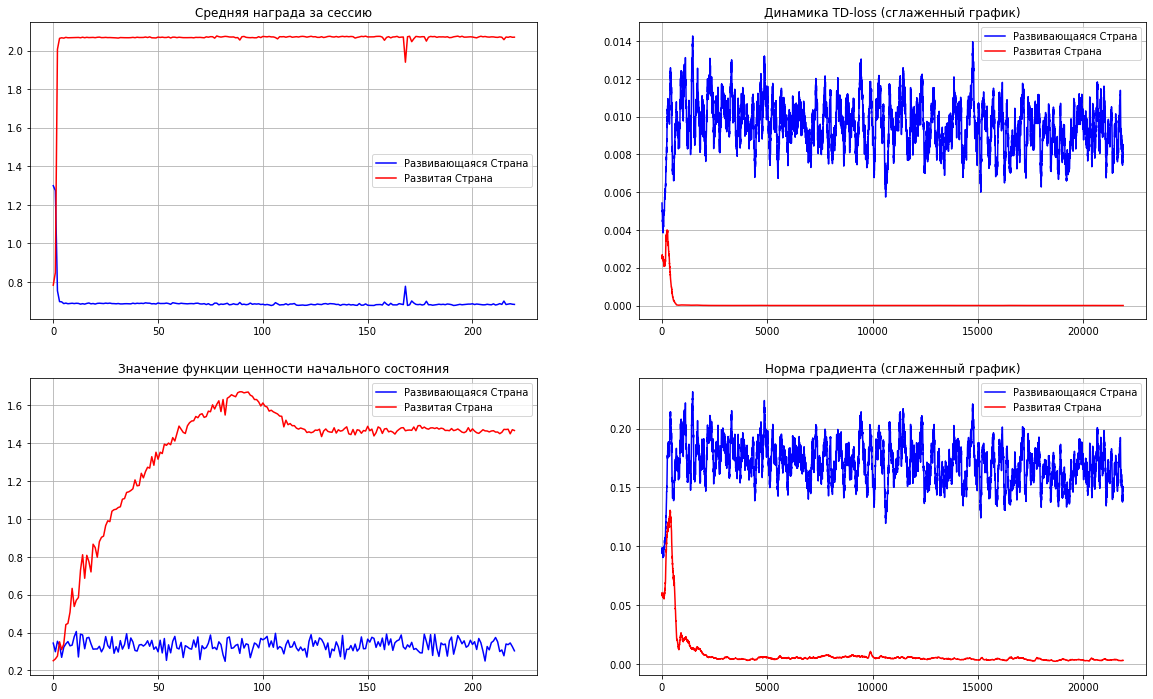

 37%|███▋      | 1104146/3000001 [2:11:07<3:45:08, 140.35it/s]


KeyboardInterrupt: 

In [23]:
state = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        for agent in agents_second:
            agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agents_second, env, exp_replays, timesteps_per_epoch)

        # train
        for i in range(len(agents_second)):
            # sampling batch_size of data from experience replay>
            s_batch, a_batch, r_batch, next_s_batch, done_batch = exp_replays[i].sample(batch_size)

            loss = compute_td_loss(s_batch, a_batch, r_batch, next_s_batch, done_batch,
                                   agents_second[i], target_networks[i])

            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(agents_second[i].parameters(), max_grad_norm)
            if i == 1:
                opts[i].step()
            opts[i].zero_grad()

            if step % loss_freq == 0:
                td_loss_history[i].append(loss.data.cpu().item())
                grad_norm_history[i].append(grad_norm.cpu())

            if step % refresh_target_network_freq == 0:
                # Load agent weights into target_network
                target_networks[i].load_state_dict(agents_second[i].state_dict())

        if step % eval_freq == 0:
            rewards = (evaluate(
                make_env(), agents_second, n_games=50, greedy=True)
            )
            for i in range(len(agents_second)):
                mean_rw_history[i].append(rewards[i])
                initial_state_q_values = agents_second[i].get_qvalues(
                    [make_env().reset()]
                )
                initial_state_v_history[i].append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replays[0]), agents_second[0].epsilon))

            fig = plt.figure(figsize=[20, 12])
            axes = fig.subplots(2, 2)

            for i in range(len(agents_second)):
                axes[0][0].plot(mean_rw_history[i], c=colors[i], label=agent_names[i])

                assert not np.isnan(td_loss_history[i][-1])
                axes[0][1].plot(smoothen(td_loss_history[i]), c=colors[i], label=agent_names[i])

                axes[1][0].plot(initial_state_v_history[i], c=colors[i], label=agent_names[i])

                axes[1][1].plot(smoothen(grad_norm_history[i]), c=colors[i], label=agent_names[i])
            
            axes[0][0].set_title('Средняя награда за сессию')
            axes[0][0].grid()
            axes[0][0].legend()

            axes[0][1].set_title("Динамика TD-loss (сглаженный график)")
            axes[0][1].grid()
            axes[0][1].legend()
            
            axes[1][0].set_title("Значение функции ценности начального состояния")
            axes[1][0].grid()
            axes[1][0].legend()
            
            axes[1][1].set_title("Норма градиента (сглаженный график)")
            axes[1][1].grid()
            axes[1][1].legend()

            plt.show()

In [49]:
evaluate(make_env(), agents_second, n_games=100, greedy=True)

array([-0.35484877,  2.41618565])

## Closed Borders Case

In [25]:
class ClosedBordersAgent:
    def __init__(self, actions_count):
        self.actions_count = actions_count

    def get_qvalues(self, state_batch):
        qvalues = np.zeros([len(state_batch), self.actions_count])
        qvalues[:, 0] = 1
        return qvalues
    
    def sample_actions(self, qvalues):
        return np.zeros(qvalues.shape[0])

In [26]:
class OpenedBordersAgent:
    def __init__(self, actions_count):
        self.actions_count = actions_count

    def get_qvalues(self, state_batch):
        qvalues = np.zeros([len(state_batch), self.actions_count])
        qvalues[:, -1] = 1
        return qvalues
    
    def sample_actions(self, qvalues):
        return np.zeros(qvalues.shape[0]) + self.actions_count - 1

In [27]:
class RandomAgent:
    def __init__(self, actions_count):
        self.actions_count = actions_count

    def get_qvalues(self, state_batch):
        qvalues = np.zeros([len(state_batch), self.actions_count])
        qvalues[:, np.random.randint(self.actions_count)] = 1
        return qvalues
    
    def sample_actions(self, qvalues):
        return np.random.randint(self.actions_count, size=qvalues.shape[0])

In [110]:
oba = OpenedBordersAgent(n_actions)
cba = ClosedBordersAgent(n_actions)
ra = RandomAgent(n_actions)

In [111]:
evaluate(make_env(), [ra, ra], n_games=100, greedy=True)

array([0.66080687, 2.04687171])

In [117]:
evaluate(make_env(), [ra, oba], n_games=100, greedy=True)

array([0.36290546, 2.22891149])

In [113]:
evaluate(make_env(), [ra, cba], n_games=100, greedy=True)

array([1.04095328, 1.62875049])

In [116]:
evaluate(make_env(), [ra, agents_both[1]], n_games=100, greedy=True)

array([0.36330177, 2.22945322])

In [118]:
evaluate(make_env(), [oba, ra], n_games=100, greedy=True)

array([0.37480435, 2.22264104])

In [119]:
evaluate(make_env(), [oba, oba], n_games=100, greedy=True)

array([0.01569911, 2.33298601])

In [120]:
evaluate(make_env(), [oba, cba], n_games=100, greedy=True)

array([0.68653493, 2.06718748])

In [121]:
evaluate(make_env(), [oba, agents_both[1]], n_games=100, greedy=True)

array([0.05183007, 2.32443492])

In [122]:
evaluate(make_env(), [cba, ra], n_games=100, greedy=True)

array([1.03263897, 1.65148568])

In [155]:
evaluate(make_env(), [cba, oba], n_games=100, greedy=True)

array([0.68267013, 2.06532296])

In [124]:
evaluate(make_env(), [cba, cba], n_games=100, greedy=True)

array([1.39053476, 0.50317546])

In [125]:
evaluate(make_env(), [cba, agents_both[1]], n_games=100, greedy=True)

array([0.68832658, 2.06903455])

In [126]:
evaluate(make_env(), [agents_both[0], ra], n_games=100, greedy=True)

array([1.02727215, 1.66870337])

In [156]:
evaluate(make_env(), [agents_both[0], oba], n_games=100, greedy=True)

array([0.68812919, 2.07431668])

In [128]:
evaluate(make_env(), [agents_both[0], cba], n_games=100, greedy=True)

array([1.39100744, 0.50237239])

In [157]:
evaluate(make_env(), [agents_both[0], agents_both[1]], n_games=100, greedy=True)

array([0.69973618, 2.07416554])

# Plots

In [28]:
class CapitalLaborEnvironmentWithTracking(CapitalLaborEnvironment):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.y = None
        self.r = None
        self.w = None
        self.params_shift = [[] for _ in range(self.n_countries)]
    
    def _capital_labour_differential(self, capital_labour, t):
        capital_differential = np.zeros(self.n_countries)
        labour_differential = np.zeros(self.n_countries)
        capital = capital_labour[:self.n_countries]
        labour = capital_labour[self.n_countries:]

        r = np.zeros(self.n_countries)
        w = np.zeros(self.n_countries)
        for country_index in range(self.n_countries):
            r[country_index] = self.capital_output_ratio[country_index] * self.output_elasticity[country_index] * \
                               (labour[country_index] / capital[country_index])**(1 - self.output_elasticity[country_index])
            w[country_index] = self.lambda0[country_index] * (1 - self.output_elasticity[country_index]) * \
                               (capital[country_index] / labour[country_index])**self.output_elasticity[country_index]
        
        ys = []
        for i in range(self.n_countries):
            y = capital[i]**self.output_elasticity[i] * labour[i]**(1 - self.output_elasticity[i])
            ys.append(y)

            capital_differential[i] = self.saving_rate[i] * self.capital_output_ratio[i] * y
            capital_differential[i] -= self.depreciation_rate[i] * capital[i]

            labour_differential[i] = self.population_growth_rate[i] * labour[i]

            for j in range(self.n_countries):
                if i == j:
                    continue

                if r[i] > r[j]:
                    capital_differential[i] += self.tau[i, j] * (r[i] - r[j]) * self.pi0[j, i] * capital[j]
                else:
                    capital_differential[i] -= self.tau[j, i] * (r[j] - r[i]) * capital[i]

                if w[i] > w[j]:
                    labour_differential[i] += self.sigma[i, j] * (w[i] - w[j]) / w[j] * self.rho0[j, i] * labour[j]
                else:
                    labour_differential[i] -= self.sigma[j, i] * (w[j] - w[i]) / w[i] * labour[i]
        
        self.y = np.array(ys)
        self.w = w
        self.r = r

        return np.hstack([capital_differential, labour_differential])
    
    def _perform_action(self, country_index, action):
        assert 0 <= action < self.get_actions_count(), "Incorrect action."
        self.params_shift[country_index] = []
        
        self.penalty_for_policy_change[country_index] = 0

        divider = 1
        new_sigma_index = []
        for i in range(self.n_countries - 1):
            for j in range(2):
                index_shift = (action // divider) % self.n_actions_per_parameter - self.n_actions_per_parameter // 2
                divider *= self.n_actions_per_parameter
                new_sigma_index.append(np.clip(self.sigma_index[country_index][i][j] + index_shift, 0, self.n_discrete_sigma - 1))
                self.penalty_for_policy_change[country_index] += abs(index_shift)
                
                self.params_shift[country_index].append(index_shift)

        new_tau_index = []
        for i in range(self.n_countries - 1):
            for j in range(2):
                index_shift = (action // divider) % self.n_actions_per_parameter - self.n_actions_per_parameter // 2
                divider *= self.n_actions_per_parameter
                new_tau_index.append(np.clip(self.tau_index[country_index][i][j] + index_shift, 0, self.n_discrete_tau - 1))
                self.penalty_for_policy_change[country_index] += abs(index_shift)
                
                self.params_shift[country_index].append(index_shift)

        self.sigma_index[country_index] = np.array(new_sigma_index).reshape(-1, 2)
        self.tau_index[country_index] = np.array(new_tau_index).reshape(-1, 2)

        
def make_tracking_env(n_steps=100):
    return CapitalLaborEnvironmentWithTracking(
        n_countries=2,
        n_steps=n_steps,
        n_discrete_sigma=10,
        n_discrete_tau=10,
        n_actions_per_parameter=3,
        n_euler_segments=11,
        output_elasticity=[1/3, 1/3],
        population_growth_rate=[0.0143, 0.0042],
        depreciation_rate=[0.05, 0.05],
        saving_rate=[0.2185, 0.228],
        lambda0=[12369, 91363],
        capital_output_ratio=[0.324, 0.2193],
        rho0=[[1, 5.4], [1/5.4, 1]],
        sigma_range=[0, 0.003],
        tau_range=[0, 0.7]
    )

In [29]:
def evaluate_with_tracking(env, agents, n_games=1, t_max=1000):
    """
    Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward
    """
    rewards = [[] for _ in range(len(agents))]
    rewards_history = [[] for _ in range(len(agents))]
    y_history = [[] for _ in range(len(agents))]
    w_history = [[] for _ in range(len(agents))]
    r_history = [[] for _ in range(len(agents))]
    tau_history = []
    sigma_history = []
    params_shift_history = [[] for _ in range(len(agents))]

    for _ in range(n_games):
        s = env.reset()
        game_rewards = [0] * len(agents)
        for _ in range(t_max):
            actions = []
            for agent in agents:
                qvalues = agent.get_qvalues([s])
                actions.append(qvalues.argmax(axis=-1)[0])
            s, r_all, done = env.step(actions)
            tau_history.append(env.tau)
            sigma_history.append(env.sigma)
            for i, r_agent in enumerate(r_all):
                game_rewards[i] += r_agent
                rewards_history[i].append(r_agent)
                y_history[i].append(env.y[i])
                w_history[i].append(env.w[i])
                r_history[i].append(env.r[i])
                params_shift_history[i].append(env.params_shift[i])
            if done:
                break
        for i in range(len(agents)):
            rewards[i].append(game_rewards[i])

    return np.mean(rewards, axis=1), rewards_history, y_history, w_history, r_history, \
           tau_history, sigma_history, params_shift_history

In [30]:
def plot_history(rewards_history, y_history, w_history, r_history):
    fig = plt.figure(figsize=(20, 12))
    axes = fig.subplots(2, 2)
    
    axes[0][0].set_title('Награда')
    axes[0][0].plot(rewards_history[0], c='blue', label='Развивающаяся Страна')
    axes[0][0].plot(rewards_history[1], c='red', label='Развитая Страна')
    axes[0][0].grid()
    axes[0][0].legend()
    
    axes[0][1].set_title('Значение Производственной Функции (y)')
    axes[0][1].plot(y_history[0], c='blue', label='Развивающаяся Страна')
    axes[0][1].plot(y_history[1], c='red', label='Развитая Страна')
    axes[0][1].grid()
    axes[0][1].legend()
    
    axes[1][0].set_title('Ставка Капитала (r)')
    axes[1][0].plot(r_history[0], c='blue', label='Развивающаяся Страна')
    axes[1][0].plot(r_history[1], c='red', label='Развитая Страна')
    axes[1][0].grid()
    axes[1][0].legend()
    
    axes[1][1].set_title('Уровень Заработных Плат (w)')
    axes[1][1].plot(w_history[0], c='blue', label='Развивающаяся Страна')
    axes[1][1].plot(w_history[1], c='red', label='Развитая Страна')
    axes[1][1].grid()
    axes[1][1].legend()

    plt.show()
    
def plot_params_shift_history(history):
    history = np.array(history)
    fig = plt.figure(figsize=(20, 12))
    axes = fig.subplots(2, 2)
    
    axes[0][0].set_title('$T_{12}$')    
    axes[0][0].plot(history[0, :, 2], c='blue', label='Развивающаяся Страна')
    axes[0][0].plot(history[1, :, 2], c='red', label='Развитая Страна')
    axes[0][0].grid()
    axes[0][0].legend()

    axes[0][1].set_title('$T_{21}$')    
    axes[0][1].plot(history[0, :, 3], c='blue', label='Развивающаяся Страна')
    axes[0][1].plot(history[1, :, 3], c='red', label='Развитая Страна')
    axes[0][1].grid()
    axes[0][1].legend()
    
    axes[1][0].set_title('$\sigma_{12}$')    
    axes[1][0].plot(history[0, :, 0], c='blue', label='Развивающаяся Страна')
    axes[1][0].plot(history[1, :, 0], c='red', label='Развитая Страна')
    axes[1][0].grid()
    axes[1][0].legend()
    
    axes[1][1].set_title('$\sigma_{21}$')    
    axes[1][1].plot(history[0, :, 1], c='blue', label='Развивающаяся Страна')
    axes[1][1].plot(history[1, :, 1], c='red', label='Развитая Страна')
    axes[1][1].grid()
    axes[1][1].legend()
    
    plt.show()
    
def plot_tau_sigma(tau, sigma):
    tau = np.array(tau)
    sigma = np.array(sigma)
    fig = plt.figure(figsize=(20, 12))
    axes = fig.subplots(2, 2)
    
    axes[0][0].set_title('$T_{12}$')    
    axes[0][0].plot(tau[:, 0, 1], c='red')
    axes[0][0].grid()

    axes[0][1].set_title('$T_{21}$')    
    axes[0][1].plot(tau[:, 1, 0], c='green')
    axes[0][1].grid()
    
    axes[1][0].set_title('$\sigma_{12}$')    
    axes[1][0].plot(sigma[:, 0, 1], c='red')
    axes[1][0].grid()
    
    axes[1][1].set_title('$\sigma_{21}$')    
    axes[1][1].plot(sigma[:, 1, 0], c='green')
    axes[1][1].grid()
    
    plt.show()

In [34]:
rewards, rewards_history, y_history, w_history, r_history, tau, sigma, params_shift_history = \
        evaluate_with_tracking(make_tracking_env(), agents_both)
rewards

array([0.70820517, 2.06811918])

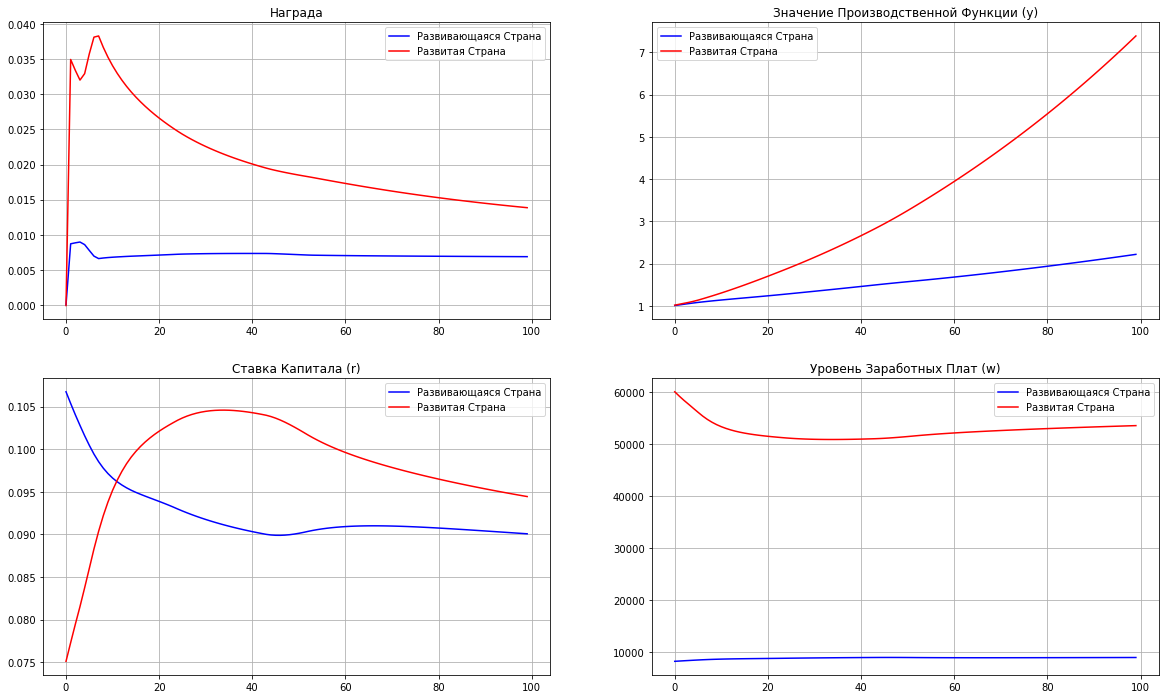

In [35]:
plot_history(rewards_history, y_history, w_history, r_history)

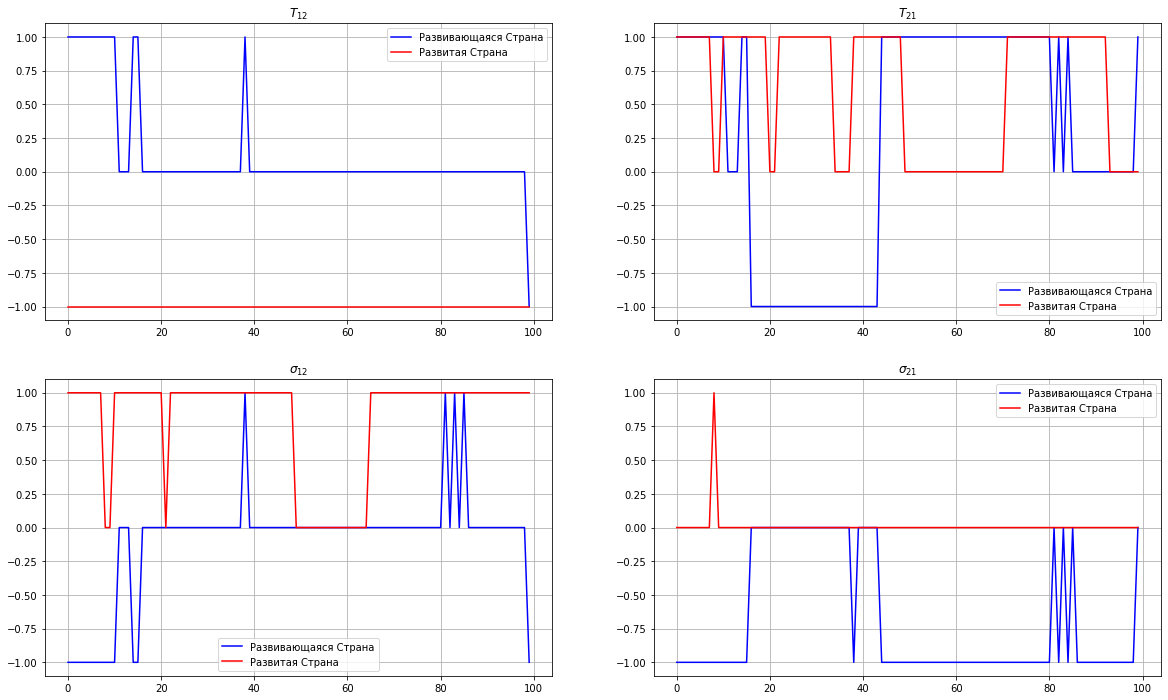

In [36]:
plot_params_shift_history(params_shift_history)

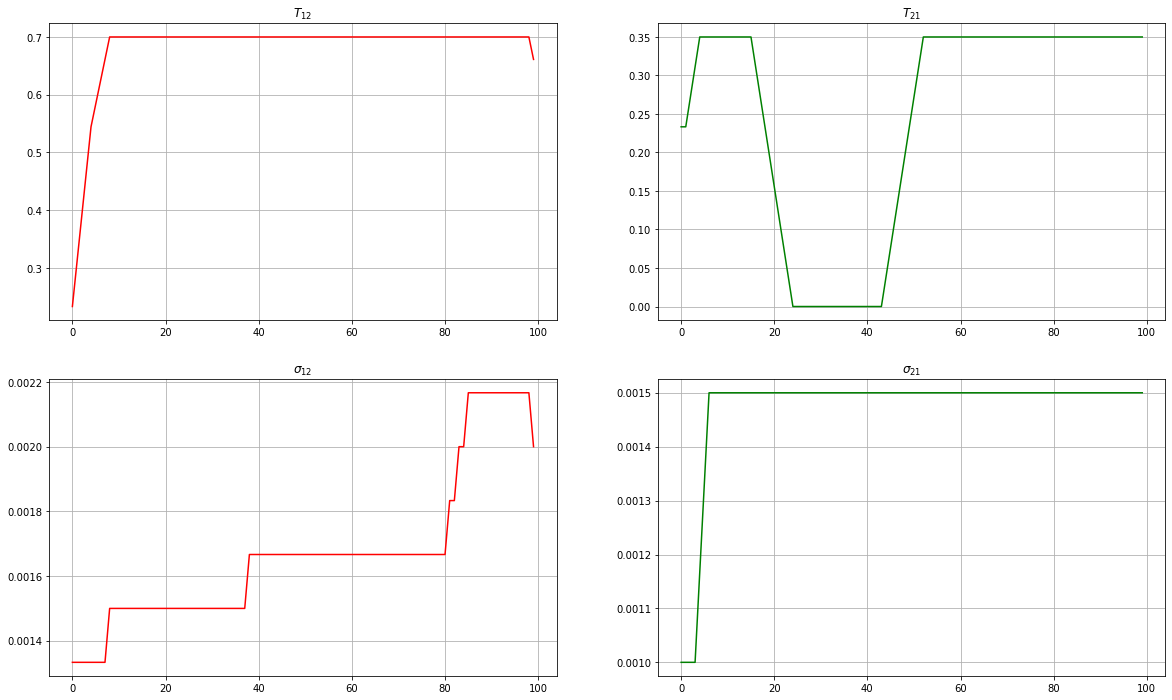

In [37]:
plot_tau_sigma(tau, sigma)